In [1]:
# we are going to load the data from the csv files in the flight data folder
# the csv file contains columns of data for each variable
# we will load the data into a dict with the key being the variable name
# and the value being a np array of the data

import numpy as np
import csv
import pandas as pd

def Rmat(phi, theta, psi):
    Rx = np.array([[1, 0, 0], [0, np.cos(phi), -np.sin(phi)], [0, np.sin(phi), np.cos(phi)]])
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],[0, 1, 0],[-np.sin(theta), 0, np.cos(theta)]])
    Rz = np.array([[np.cos(psi), -np.sin(psi), 0],[np.sin(psi), np.cos(psi), 0], [0, 0, 1]])
    R = Rz@Ry@Rx
    return R


def load_log_file(log_file):
    # read rows of the csv file
    df = pd.read_csv(log_file)
    # convert to dictionary
    log_dict = dict()
    for key in df.columns:
        log_dict.update({key: np.array(df[key])})

    # rename the variables
    rename_dict = {
        'time': 't',
        'pos_x': 'x',
        'pos_y': 'y',
        'pos_z': 'z',
        'vel_x': 'vx',
        'vel_y': 'vy',
        'vel_z': 'vz',
        'att_phi': 'phi',
        'att_theta': 'theta',
        'att_psi': 'psi',
        'rate_p': 'p',
        'rate_q': 'q',
        'rate_r': 'r',
        'rpm_obs_1': 'w1',
        'rpm_obs_2': 'w2',
        'rpm_obs_3': 'w3',
        'rpm_obs_4': 'w4',
        'rpm_ref_1': 'u1',
        'rpm_ref_2': 'u2',
        'rpm_ref_3': 'u3',
        'rpm_ref_4': 'u4',
    }
    log_dict.update({rename_dict[key]: log_dict.pop(key) for key in rename_dict.keys()})

    # extra variables

    # u = normalized rpm commands
    log_dict['u'] = np.stack([log_dict['u1'], log_dict['u2'], log_dict['u3'], log_dict['u4']]).T
    umin = log_dict['u'].min()
    umax = log_dict['u'].max()
    log_dict['u'] = (log_dict['u']-umin)/(umax-umin)

    # vbx, vby, vbz = body frame velocity
    v_body = np.stack([
        Rmat(phi, theta, psi).T@[vx, vy, vz]
        for vx, vy, vz, phi, theta, psi
        in zip(log_dict['vx'],log_dict['vy'],log_dict['vz'],log_dict['phi'],log_dict['theta'],log_dict['psi'])
    ])
    log_dict['vbx'], log_dict['vby'], log_dict['vbz'] = v_body.T

    # speed
    log_dict['V'] = np.linalg.norm(v_body, axis=1)

    # abx, aby, abz = accelerometer readings body frame
    log_dict['abx'] = log_dict['ekf_U1']-log_dict['ekf_X10']
    log_dict['aby'] = log_dict['ekf_U2']-log_dict['ekf_X11']
    log_dict['abz'] = log_dict['ekf_U3']-log_dict['ekf_X12']

    # only log when netork is active
    indices = log_dict['autopilot_mode']>0
    log_dict = {key: log_dict[key][indices] for key in log_dict.keys()}

    # set t=0
    log_dict['t'] = log_dict['t']-log_dict['t'][0]

    return log_dict

In [2]:
import os
# list all files in flight_data folder
folder = '/mnt/c/Users/robinferede/Desktop/flight_data/ppo_network/9sep'
folder = '/mnt/c/Users/robinferede/Desktop/flight_data/gcnet_vs_min_snap'
# folder = 'flight_data/2sep'
files = os.listdir(folder)
list(enumerate(files))

[(0, 'gcnet_switch_1.2m_heavy_bumper.csv'),
 (1, 'gcnet_switch_1.2m_light_bumper.csv'),
 (2, 'gcnet_switch_1.2m_no_bumper.csv'),
 (3, 'min_snap_alpha=1.0_heavy_bumpers_ADAPTIVE_TRUE.csv'),
 (4, 'min_snap_heavy_bumbers.csv'),
 (5, 'min_snap_light_bumber.csv'),
 (6, 'min_snap_no_bumpers.csv')]

In [3]:
folder = '/mnt/c/Users/robinferede/Desktop/flight_data/ppo_network/'

# E2E flights
# log_e2e_sim = dict(np.load('flight_data/simulation_logs/E2E_NET_sim.npz'))
# log_e2e1 = load_log_file(folder+'2sep/new_drone_ppo_end_to_end.csv')
# log_e2e2 = load_log_file(folder+'8sep/SuccesfullE2E_with_nn_drone_model.csv') 
# log_e2e3 = load_log_file(folder+'9sep/E2E_test1.csv') 
# log_e2e4 = load_log_file(folder+'9sep/E2E_test2.csv') 
# log_e2e5 = load_log_file(folder+'9sep/E2E_test3[new_drone].csv') # FASTEST

# ALTERNATIVE E2E flights
log_e2e_sim = dict(np.load('flight_data/simulation_logs/E2E_NET_sim_with_gate_penalty.npz'))
log_e2e1 = load_log_file(folder+'11sep/E2E1.csv')
log_e2e2 = load_log_file(folder+'11sep/E2E2.csv')
log_e2e3 = load_log_file(folder+'11sep/E2E3.csv')
log_e2e4 = load_log_file(folder+'11sep/E2E4.csv')
log_e2e5 = load_log_file(folder+'11sep/E2E5.csv')


# INDI flights
# log_INDI_sim = dict(np.load('flight_data/simulation_logs/INDI_NET_sim.npz'))
# log_INDI1 = load_log_file(folder+'7sep/INDInet_no_rate_penalty_pq3.csv')
# log_INDI2 = load_log_file(folder+'7sep/new_drone_INDI_low_lim.csv') # FASTEST
# log_INDI3 = load_log_file(folder+'8sep/INDI_net_pqlim=3.csv')
# log_INDI4 = load_log_file(folder+'9sep/INDI_test1.csv')
# log_INDI5 = load_log_file(folder+'9sep/INDI_test_2[new_drone].csv')

# ALTERNATIVE INDI flights
log_INDI_sim = dict(np.load('flight_data/simulation_logs/INDI_NET_sim_with_gate_penalty.npz'))
log_INDI1 = load_log_file(folder+'11sep/INDI1.csv')
log_INDI2 = load_log_file(folder+'11sep/INDI2.csv')
log_INDI3 = load_log_file(folder+'11sep/INDI3.csv')
log_INDI4 = load_log_file(folder+'11sep/INDI4.csv')
log_INDI5 = load_log_file(folder+'11sep/INDI5.csv')

# MIN_SNAP flight
# npz_file = folder+'9sep/min_snap_fastest.npz'
# log_MIN_SNAP = dict(np.load(npz_file))
# log_MIN_SNAP['z'] -= .5



In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

from quadcopter_animation import animation

# color map
norm_ = mpl.colors.Normalize(0, 7)
cmap_ = cm.jet

# hard coded gate pos, yaw
gate_pos = np.array([
    [ 2,-1.5,-1.5],
    [ 2, 1.5,-1.5],
    [-2, 1.5,-1.5],
    [-2,-1.5,-1.5]
])

gate_yaw = np.array([
    1*np.pi/4,
    3*np.pi/4,
    5*np.pi/4,
    7*np.pi/4
])

def color_plot(x_axis, y_axis, color_axis, step=10):
    for i in reversed(range(step,len(x_axis),step)):
        ax = plt.gca()
        ax.plot([x_axis[i-step], x_axis[i]], [y_axis[i-step], y_axis[i]], color=cmap_(norm_(color_axis[i])))

def plot_gate(x,y,yaw):
    r = 0.5
    right_side = np.array([x+r*np.cos(yaw+np.pi/2), y+r*np.sin(yaw+np.pi/2)])
    left_side = np.array([x+r*np.cos(yaw-np.pi/2), y+r*np.sin(yaw-np.pi/2)])

    plt.scatter(right_side[0], right_side[1], color='k', zorder=3)
    plt.scatter(left_side[0], left_side[1], color='k', zorder=3)
    plt.plot([right_side[0], left_side[0]], [right_side[1], left_side[1]], color='k', linestyle='--')

def top_view_plot(log_dict, title='', step=10, color_bar=True):
    # plt.figure(figsize=(5,5))
    color_plot(log_dict['y'], log_dict['x'], log_dict['V'], step=step)
    
    # hard coded gate visualisation
    plot_gate(-1.5, 2, 1*np.pi/4)
    plot_gate( 1.5, 2, 3*np.pi/4)
    plot_gate( 1.5,-2, 5*np.pi/4)
    plot_gate(-1.5,-2, 7*np.pi/4)

    plt.xlabel('y [m]')
    plt.ylabel('x [m]')
    plt.axis('equal')
    plt.grid(True)
    plt.title(title, fontweight='bold')

    # colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm_)
    sm.set_array([])
    if color_bar == 'left':
        plt.colorbar(sm, label='V [m/s]', location='left')
    elif color_bar:
        plt.colorbar(sm, label='V [m/s]')
    # plt.show()

def animate_side_by_side(*trajs, **kwargs):
    import importlib
    importlib.reload(animation)    
    animation.animate(
        [traj['t'] for traj in trajs],
        [traj['x'] for traj in trajs],
        [traj['y'] for traj in trajs],
        [traj['z'] for traj in trajs],
        [traj['phi'] for traj in trajs],
        [traj['theta'] for traj in trajs],
        [traj['psi'] for traj in trajs],
        [traj['u'] for traj in trajs],
        multiple_trajectories=True,
        simultaneous=True,
        **kwargs
    )

def get_gate_passage_times(traj, num_gates=4*6):
    t = traj['t']
    x = traj['x']
    y = traj['y']
    target = 0
    gate_passage_times = [0]
    for i in range(1, len(t)):
        target_pos = gate_pos[target][0:2]
        target_yaw = gate_yaw[target]

        pos_new = np.array([x[i], y[i]])
        pos_old = np.array([x[i-1], y[i-1]])

        # check if the drone passed the gate
        normal = np.array([np.cos(target_yaw), np.sin(target_yaw)])
        if np.dot(normal, pos_new-target_pos) > 0 and np.dot(normal, pos_old-target_pos) < 0:
            gate_passage_times.append(t[i])
            target += 1
            target = target%len(gate_pos)
        
        # stop after passing num_laps gates
        if len(gate_passage_times) > num_gates:
            break
    return gate_passage_times

def get_lap_times(traj):
    gate_passage_times = np.array(get_gate_passage_times(traj))
    lap_times = gate_passage_times[4::4] - gate_passage_times[:-4:4]
    return lap_times


In [5]:
get_lap_times(log_e2e1)

array([3.227534, 2.793943, 2.806637, 2.835934, 2.8418  , 2.831055])

In [6]:
# cut the trajectories to 6 laps
indices_e2e_sim = log_e2e_sim['t'] <= get_gate_passage_times(log_e2e_sim)[-1]
indices_e2e1 = log_e2e1['t'] <= get_gate_passage_times(log_e2e1)[-1]
indices_e2e2 = log_e2e2['t'] <= get_gate_passage_times(log_e2e2)[-1]
indices_e2e3 = log_e2e3['t'] <= get_gate_passage_times(log_e2e3)[-1]
indices_e2e4 = log_e2e4['t'] <= get_gate_passage_times(log_e2e4)[-1]
indices_e2e5 = log_e2e5['t'] <= get_gate_passage_times(log_e2e5)[-1]

indices_INDI_sim = log_INDI_sim['t'] <= get_gate_passage_times(log_INDI_sim)[-1]
indices_INDI1 = log_INDI1['t'] <= get_gate_passage_times(log_INDI1)[-1]
indices_INDI2 = log_INDI2['t'] <= get_gate_passage_times(log_INDI2)[-1]
indices_INDI3 = log_INDI3['t'] <= get_gate_passage_times(log_INDI3)[-1]
indices_INDI4 = log_INDI4['t'] <= get_gate_passage_times(log_INDI4)[-1]
indices_INDI5 = log_INDI5['t'] <= get_gate_passage_times(log_INDI5)[-1]

# cut the trajectories to 6 laps
log_e2e_sim = {key: log_e2e_sim[key][indices_e2e_sim] for key in log_e2e_sim.keys()}
log_e2e1 = {key: log_e2e1[key][indices_e2e1] for key in log_e2e1.keys()}
log_e2e2 = {key: log_e2e2[key][indices_e2e2] for key in log_e2e2.keys()}
log_e2e3 = {key: log_e2e3[key][indices_e2e3] for key in log_e2e3.keys()}
log_e2e4 = {key: log_e2e4[key][indices_e2e4] for key in log_e2e4.keys()}
log_e2e5 = {key: log_e2e5[key][indices_e2e5] for key in log_e2e5.keys()}

log_INDI_sim = {key: log_INDI_sim[key][indices_INDI_sim] for key in log_INDI_sim.keys()}
log_INDI1 = {key: log_INDI1[key][indices_INDI1] for key in log_INDI1.keys()}
log_INDI2 = {key: log_INDI2[key][indices_INDI2] for key in log_INDI2.keys()}
log_INDI3 = {key: log_INDI3[key][indices_INDI3] for key in log_INDI3.keys()}
log_INDI4 = {key: log_INDI4[key][indices_INDI4] for key in log_INDI4.keys()}
log_INDI5 = {key: log_INDI5[key][indices_INDI5] for key in log_INDI5.keys()}


In [7]:
animate_side_by_side(
    log_e2e1,
    log_e2e2,
    log_e2e3,
    log_e2e4,
    log_e2e5,
    gate_pos=gate_pos,
    gate_yaw=gate_yaw,
    colors=[(255,0,0), (0,255,0), (0,0,255), (255,255,0), (0,255,255)],
    names=['E2E1', 'E2E2', 'E2E3', 'E2E4', 'E2E5'],
)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52

In [8]:
# E2E2 wins, 6 laps
log_e2e_fastest = log_e2e2

In [9]:
animate_side_by_side(
    log_INDI1,
    log_INDI2,
    log_INDI3,
    log_INDI4,
    log_INDI5,
    gate_pos=gate_pos,
    gate_yaw=gate_yaw,
    colors=[(255,0,0), (0,255,0), (0,0,255), (255,255,0), (0,255,255)],
    names=['INDI1', 'INDI2', 'INDI3', 'INDI4', 'INDI5'],
)


QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52

In [10]:
# INDI2 wins, 6 laps
log_INDI_fastest = log_INDI2

In [11]:
animate_side_by_side(
    log_e2e_fastest, log_INDI_fastest,
    gate_pos=gate_pos,
    gate_yaw=gate_yaw,
    colors=[(255,0,0),(0,255,0)],
    names=['E2E Net', 'INDI'],
)

animate_side_by_side(
    log_e2e_fastest, log_e2e_sim,
    gate_pos=gate_pos,
    gate_yaw=gate_yaw,
    colors=[(255,0,0),(0,255,0)],
    names=['E2E Net', 'E2E Net Sim'],
)

animate_side_by_side(
    log_INDI_fastest, log_INDI_sim,
    gate_pos=gate_pos,
    gate_yaw=gate_yaw,
    colors=[(255,0,0),(0,255,0)],
    names=['INDI Net', 'INDI Net Sim'],
)

animate_side_by_side(
    log_e2e_sim, log_INDI_sim,
    gate_pos=gate_pos,
    gate_yaw=gate_yaw,
    colors=[(0,255,0), (255,0,0)],
    names=['E2E Net', 'INDI Net'],
)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52920).
Cannot move to target thread (0x19f3f40)

QObject::moveToThread: Current thread (0x19f3f40) is not the object's thread (0xf52

## Top view plots fastest networks

/tmp/ipykernel_615/1974450401.py:60: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='V [m/s]', location='left')
/tmp/ipykernel_615/2641298080.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


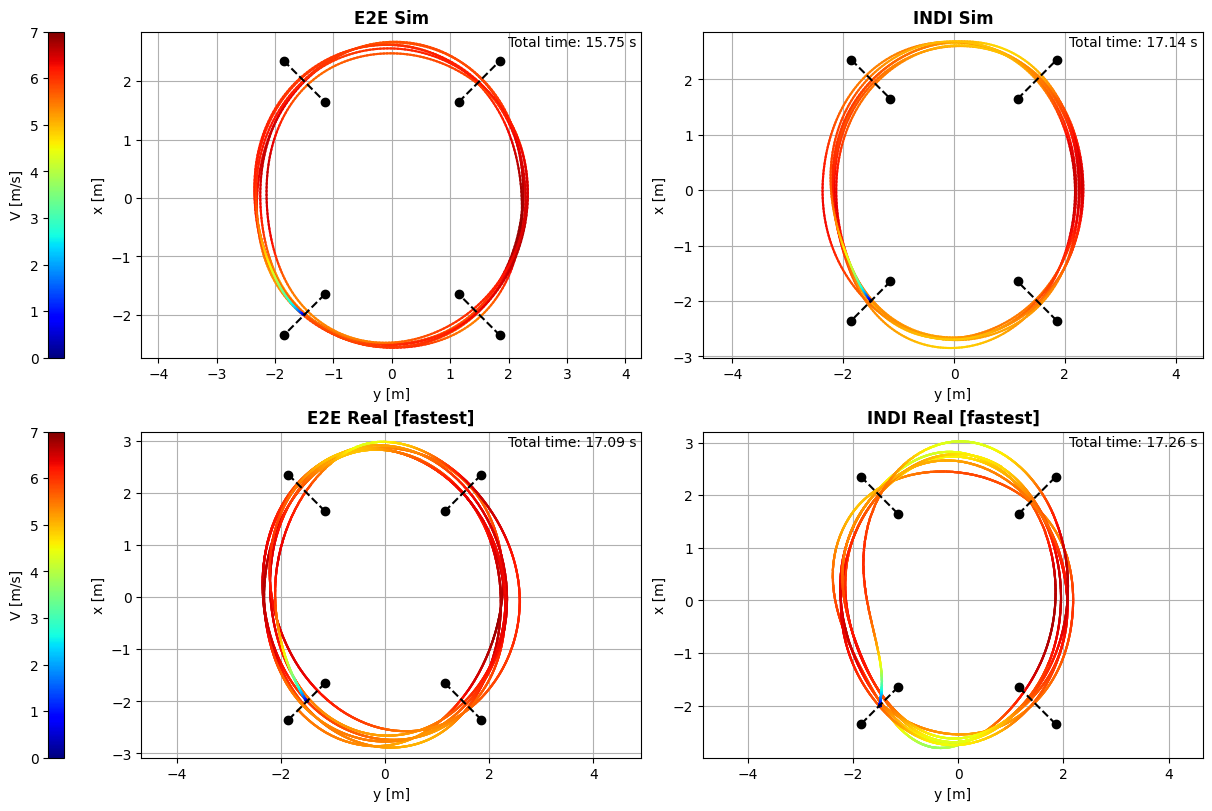

In [12]:
# 2 x 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12,8), constrained_layout=True, gridspec_kw={'width_ratios': [3,3]})
plt.sca(axs[0,0])
T = get_lap_times(log_e2e_sim).sum()
top_view_plot(log_e2e_sim, title=f'E2E Sim' , step=1, color_bar='left')
plt.text(0.99, 0.99, f'Total time: {T:.2f} s', horizontalalignment='right', verticalalignment='top', transform=axs[0,0].transAxes)
plt.sca(axs[0,1])
T = get_lap_times(log_INDI_sim).sum()
top_view_plot(log_INDI_sim, title=f'INDI Sim', step=1, color_bar=False)
plt.text(0.99, 0.99, f'Total time: {T:.2f} s', horizontalalignment='right', verticalalignment='top', transform=axs[0,1].transAxes)
plt.sca(axs[1,0])
T = get_lap_times(log_e2e_fastest).sum()
top_view_plot(log_e2e_fastest, title=f'E2E Real [fastest]', step=1, color_bar='left')
plt.text(0.99, 0.99, f'Total time: {T:.2f} s', horizontalalignment='right', verticalalignment='top', transform=axs[1,0].transAxes)
plt.sca(axs[1,1])
T = get_lap_times(log_INDI_fastest).sum()
top_view_plot(log_INDI_fastest, title=f'INDI Real [fastest]', step=1, color_bar=False)
plt.text(0.99, 0.99, f'Total time: {T:.2f} s', horizontalalignment='right', verticalalignment='top', transform=axs[1,1].transAxes)
# plt.sca(axs[0,2])
# boxsplot of laptimes ALSO SHOW DATAPOINTS
# plt.boxplot(
#     [get_lap_times(log_e2e_sim), get_lap_times(log_INDI_sim)],
#     labels=['E2E', 'INDI'],
# )
# plt.ylabel('t [s]')
# plt.grid(True)
# plt.title('Lap times Sim', fontweight='bold')
# plt.sca(axs[1,2])
# plt.boxplot(
#     [get_lap_times(log_e2e_fastest), get_lap_times(log_INDI_fastest)],
#     labels=['E2E', 'INDI'],
# )
# plt.ylabel('t [s]')
# plt.grid(True)
# plt.title('Lap times Real', fontweight='bold')

# axs[0,2] and axs[1,2] share y axis
# axs[0,2].get_shared_y_axes().join(axs[0,2], axs[1,2])

# save into figures folder
fig.savefig('Figures/top_view_comparison.pdf')
fig.show()

## Plot showing all performed flights

/tmp/ipykernel_615/2201227245.py:136: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


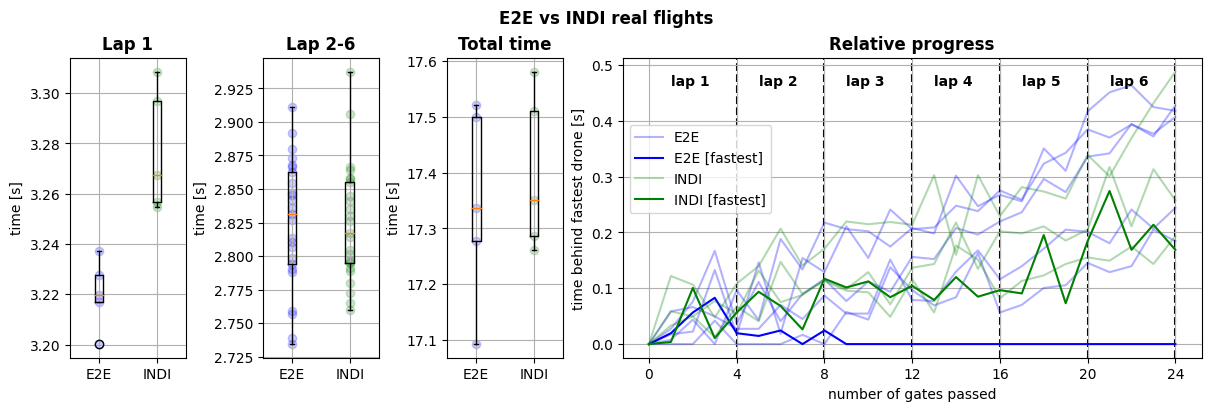

In [23]:
def progress_comparison_plot(*trajs, **kwargs):
    gate_passage_times = []
    for traj in trajs:
        gate_passage_times.append(get_gate_passage_times(traj, num_gates=kwargs['num_laps']*4))
    gate_passage_times = np.array(gate_passage_times).T
    gate_passage_times_relative = np.array([gt - min(gt) for gt in gate_passage_times])

    # for i in range(len(kwargs['names'])):
    #     name = kwargs['names'][i]
    #     alpha = kwargs['alphas'][i]
    #     if alpha == 1:
    #         kwargs['names'][i] += ' [fastest]'

    # subplots
    fig, ax = plt.subplots(1,4, figsize=kwargs['figsize'], gridspec_kw={'width_ratios': [1,1,1,5]}, constrained_layout=True)

    # box plots of laptimes
    lap_times = np.array([get_lap_times(traj) for traj in trajs])

    lap_tiems_E2E = np.array([lap_times[i] for i in range(len(lap_times)) if kwargs['names'][i].startswith('E2E')])
    lap_tiems_INDI = np.array([lap_times[i] for i in range(len(lap_times)) if kwargs['names'][i].startswith('INDI')])

    # ax[0] will show a box plot of the first lap times (include scatter plot of data points)
    alpha_scatter = 0.2
    ax[0].scatter(np.ones(len(lap_tiems_E2E[:,0]))*0, lap_tiems_E2E[:,0], color='b', alpha=alpha_scatter)
    ax[0].scatter(np.ones(len(lap_tiems_INDI[:,0]))*1, lap_tiems_INDI[:,0], color='g', alpha=alpha_scatter)
    ax[0].boxplot(lap_tiems_E2E[:,0], positions=[0], labels=['E2E'])
    ax[0].boxplot(lap_tiems_INDI[:,0], positions=[1], labels=['INDI'])
    ax[0].set_ylabel('time [s]')
    ax[0].grid(True)
    # sub title
    ax[0].set_title('Lap 1', fontweight='bold')

    # ax[1] will show a box plot of the lap 2-6 lumped together
    ax[1].scatter(np.ones(len(lap_tiems_E2E[:,1:].flatten()))*0, lap_tiems_E2E[:,1:].flatten(), color='b', alpha=alpha_scatter)
    ax[1].scatter(np.ones(len(lap_tiems_INDI[:,1:].flatten()))*1, lap_tiems_INDI[:,1:].flatten(), color='g', alpha=alpha_scatter)
    ax[1].boxplot(lap_tiems_E2E[:,1:].flatten(), positions=[0], labels=['E2E'])
    ax[1].boxplot(lap_tiems_INDI[:,1:].flatten(), positions=[1], labels=['INDI'])
    ax[1].set_ylabel('time [s]')
    ax[1].grid(True)
    # sub title
    ax[1].set_title('Lap 2-6', fontweight='bold')

    # ax[2] will show a box plot of the lap completion times (sum of lap times)
    ax[2].scatter(np.ones(len(lap_tiems_E2E.sum(axis=1)))*0, lap_tiems_E2E.sum(axis=1), color='b', alpha=alpha_scatter)
    ax[2].scatter(np.ones(len(lap_tiems_INDI.sum(axis=1)))*1, lap_tiems_INDI.sum(axis=1), color='g', alpha=alpha_scatter)
    ax[2].boxplot(lap_tiems_E2E.sum(axis=1), positions=[0], labels=['E2E'])
    ax[2].boxplot(lap_tiems_INDI.sum(axis=1), positions=[1], labels=['INDI'])
    ax[2].set_ylabel('time [s]')
    ax[2].grid(True)
    # sub title
    ax[2].set_title('Total time', fontweight='bold')

    # box plots of laptimes
    # lap_times = np.array([get_lap_times(traj) for traj in trajs])

    # lap_tiems_E2E = np.array([lap_times[i] for i in range(len(lap_times)) if kwargs['names'][i].startswith('E2E')])
    # lap_tiems_INDI = np.array([lap_times[i] for i in range(len(lap_times)) if kwargs['names'][i].startswith('INDI')])
    # for i in range(kwargs['num_laps']):
    #     # no outliers
    #     ax[0].scatter(np.ones(len(lap_tiems_E2E[:,i]))*2*i, lap_tiems_E2E[:,i], color='b', alpha=0.5)
    #     ax[0].scatter(np.ones(len(lap_tiems_INDI[:,i]))*2*i+1, lap_tiems_INDI[:,i], color='g', alpha=0.5)
    #     ax[0].boxplot(lap_tiems_E2E[:,i], positions=[2*i], labels=['E2E'])
    #     ax[0].boxplot(lap_tiems_INDI[:,i], positions=[2*i+1], labels=['INDI'])
    #     # vertical line at 2i+1.5 to separate the boxplots (dotted line)
    #     ax[0].axvline(2*i+1.5, color='k', linestyle='--', zorder=0)
    #     ymin, ymax = ax[0].get_ylim()
    #     ypos = ymin + (ymax-ymin)*.8
    #     ax[0].text(i*2, ypos, f'lap {i+1}', rotation=0, verticalalignment='bottom', fontweight='bold')

    # ax[0].set_ylabel('lap time [s]')
    # # set ylim to 0, 3.4
    # ax[0].grid(True)
    # # ax[0].legend()

    # time plot
    # for i in range(len(trajs)):
    #     ax[0].plot(gate_passage_times[:,i], label=kwargs['names'][i], color=kwargs['colors'][i], alpha=kwargs['alphas'][i], linestyle=kwargs['line_style'][i])
    # for i in range(1, kwargs['num_laps']+1):
    #     ax[0].axvline(i*4, color='k', linestyle='--', zorder=0)
    #     ymin, ymax = ax[0].get_ylim()
    #     ypos = ymin + (ymax-ymin)*.8
    #     ax[0].text(i*4-1, ypos, f'lap {i}', rotation=90, verticalalignment='bottom', fontweight='bold')
    # ax[0].set_xlabel('number of gates passed')
    # ax[0].set_ylabel('time [s]')
    # ax[0].set_xticks(np.arange(0, kwargs['num_laps']*4+1, 4))
    # ax[0].grid(True)
    # handles, labels = ax[0].get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # # put the legend on the bottom right
    # ax[0].legend(by_label.values(), by_label.keys(), loc='lower right')

    # relative time plot
    axi = ax[3]
    for i in range(len(trajs)):
        axi.plot(gate_passage_times_relative[:,i], label=kwargs['names'][i], color=kwargs['colors'][i], alpha=kwargs['alphas'][i], linestyle=kwargs['line_style'][i])
    for i in range(1, kwargs['num_laps']+1):
        axi.axvline(i*4, color='k', linestyle='--', zorder=0)
        ymin, ymax = axi.get_ylim()
        ypos = ymin + (ymax-ymin)*.9
        axi.text(i*4-3, ypos, f'lap {i}', rotation=0, verticalalignment='bottom', fontweight='bold')
    axi.set_xlabel('number of gates passed')
    axi.set_ylabel('time behind fastest drone [s]')
    axi.set_xticks(np.arange(0, kwargs['num_laps']*4+1, 4))
    axi.grid(True)
    
    # update names
    # lap time boxplot
    lap_times = gate_passage_times[4::4] - gate_passage_times[:-4:4]
    lap_times_dict = {}
    for name in kwargs['names']:
        # if name ends with " [fastest]" remove it
        if name.endswith(' [fastest]'):
            name = name[:-10]
        if name in lap_times_dict.keys():
            lap_times_dict[name] += list(lap_times[:,kwargs['names'].index(name)])
        else:
            lap_times_dict[name] = list(lap_times[:,kwargs['names'].index(name)])
    handles, labels = axi.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # put the legend on the top left (move the legend down)
    axi.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(0,1.1-0.3))
    # sub title
    axi.set_title('Relative progress', fontweight='bold')

    # pos = 0
    # for name in lap_times_dict.keys():
    #     ax[2].boxplot(lap_times_dict[name], positions=[pos], labels=[name])
    #     pos += 1
    # ax[2].set_ylabel('lap time [s]')
    # ax[2].grid(True)
    # ax[2].legend()
    fig.suptitle('E2E vs INDI real flights', fontweight='bold')
    # save
    fig.savefig('Figures/performance_comparison_plot.pdf')
    fig.show()

la = 0.3

progress_comparison_plot(
    log_e2e1, log_e2e2, log_e2e3, log_e2e4, log_e2e5,
    log_INDI1, log_INDI2, log_INDI3, log_INDI4, log_INDI5,
    num_laps=6,
    names=['E2E', 'E2E [fastest]', 'E2E', 'E2E', 'E2E', 'INDI', 'INDI [fastest]', 'INDI', 'INDI', 'INDI'],
    alphas=[la, 1, la, la, la, la, 1, la, la, la],
    line_style = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid'],
    colors=['b']*6+['g']*6,
    figsize=(12,4)
)

# Table of all laptimes

In [14]:
lap_times_dict = {
    'e2e_sim': get_lap_times(log_e2e_sim),
    'e2e1': get_lap_times(log_e2e1),
    'e2e2': get_lap_times(log_e2e2),
    'e2e3': get_lap_times(log_e2e3),
    'e2e4': get_lap_times(log_e2e4),
    'e2e5': get_lap_times(log_e2e5),
    'INDI_sim': get_lap_times(log_INDI_sim),
    'INDI1': get_lap_times(log_INDI1),
    'INDI2': get_lap_times(log_INDI2),
    'INDI3': get_lap_times(log_INDI3),
    'INDI4': get_lap_times(log_INDI4),
    'INDI5': get_lap_times(log_INDI5),
}

In [15]:
# Make a table showing the lap times
import pandas as pd
df = pd.DataFrame(lap_times_dict)
df = df[['e2e_sim', 'e2e1', 'e2e2', 'e2e3', 'e2e4', 'e2e5', 'INDI_sim', 'INDI1', 'INDI2', 'INDI3', 'INDI4', 'INDI5']]
# the first column should show the lap1, lap2, lap3, etc
df.index = ['lap'+str(i) for i in range(1,7)]
# add one row with the total time called 'total'
df.loc['total'] = df.sum()


# rename the columns
df = df.rename(columns={
    'e2e_sim': 'E2E Sim',
    'e2e1': 'E2E1',
    'e2e2': 'E2E2',
    'e2e3': 'E2E3',
    'e2e4': 'E2E4',
    'e2e5': 'E2E5',
    'INDI_sim': 'INDI Sim',
    'INDI1': 'INDI1',
    'INDI2': 'INDI2',
    'INDI3': 'INDI3',
    'INDI4': 'INDI4',
    'INDI5': 'INDI5',
})

# transpose table
df = df.T

# add row E2Emean and INDI mean
df.loc['E2E mean'] = df.loc[['E2E1', 'E2E2', 'E2E3', 'E2E4', 'E2E5']].mean()
df.loc['INDI mean'] = df.loc[['INDI1', 'INDI2', 'INDI3', 'INDI4', 'INDI5']].mean()

# show everythign with 2 decimals
df = df.round(2)

df

,lap1,lap2,lap3,lap4,lap5,lap6,total
E2E Sim,2.97,2.51,2.56,2.55,2.59,2.57,15.75
E2E1,3.23,2.79,2.81,2.84,2.84,2.83,17.34
E2E2,3.22,2.74,2.79,2.80,2.76,2.79,17.09
E2E3,3.20,2.73,2.91,2.76,2.85,2.83,17.28
E2E4,3.22,2.85,2.89,2.87,2.87,2.81,17.50
E2E5,3.24,2.81,2.85,2.86,2.87,2.88,17.52
INDI Sim,3.20,2.82,2.75,2.80,2.81,2.76,17.14
INDI1,3.30,2.86,2.80,2.86,2.91,2.79,17.51
INDI2,3.26,2.79,2.80,2.79,2.84,2.77,17.26
INDI3,3.25,2.80,2.83,2.86,2.76,2.84,17.35


In [16]:
# latex table with 2 decimals and use lines between rows
latex_table = df.to_latex(float_format="%.2f", multirow=True, multicolumn=True, multicolumn_format='c', column_format='|c|c|c|c|c|c|c|c|c|c|c|c|')

print(latex_table)

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|}
\toprule
 & lap1 & lap2 & lap3 & lap4 & lap5 & lap6 & total \\
\midrule
E2E Sim & 2.97 & 2.51 & 2.56 & 2.55 & 2.59 & 2.57 & 15.75 \\
E2E1 & 3.23 & 2.79 & 2.81 & 2.84 & 2.84 & 2.83 & 17.34 \\
E2E2 & 3.22 & 2.74 & 2.79 & 2.80 & 2.76 & 2.79 & 17.09 \\
E2E3 & 3.20 & 2.73 & 2.91 & 2.76 & 2.85 & 2.83 & 17.28 \\
E2E4 & 3.22 & 2.85 & 2.89 & 2.87 & 2.87 & 2.81 & 17.50 \\
E2E5 & 3.24 & 2.81 & 2.85 & 2.86 & 2.87 & 2.88 & 17.52 \\
INDI Sim & 3.20 & 2.82 & 2.75 & 2.80 & 2.81 & 2.76 & 17.14 \\
INDI1 & 3.30 & 2.86 & 2.80 & 2.86 & 2.91 & 2.79 & 17.51 \\
INDI2 & 3.26 & 2.79 & 2.80 & 2.79 & 2.84 & 2.77 & 17.26 \\
INDI3 & 3.25 & 2.80 & 2.83 & 2.86 & 2.76 & 2.84 & 17.35 \\
INDI4 & 3.27 & 2.78 & 2.82 & 2.76 & 2.83 & 2.83 & 17.29 \\
INDI5 & 3.31 & 2.80 & 2.86 & 2.81 & 2.87 & 2.94 & 17.58 \\
E2E mean & 3.22 & 2.79 & 2.85 & 2.82 & 2.84 & 2.83 & 17.35 \\
INDI mean & 3.28 & 2.80 & 2.82 & 2.82 & 2.84 & 2.83 & 17.40 \\
\bottomrule
\end{tabular}



# Reality Gap plots

In [ ]:
# E2E actuator modeling error

def first_order_delay(u, x0, dt, tau):
    x = np.zeros(len(u))
    x[0] = x0
    for i in range(1, len(u)):
        x[i] = x[i-1] + (u[i-1] - x[i-1]) * dt / tau
    return x

tau = 0.06
a=0.5
def plot_actuator_model_error(log_dict):
    t = log_dict['t']
    dt = np.mean(np.gradient(t))
    # 4x1 subplot showing command, obsevered and modeled rpm of each prop
    fig, axs = plt.subplots(4, 1, figsize=(6,4), sharex=True)
    plt.sca(axs[0])
    plt.plot(t, log_dict['u1'], label='command', alpha=a)
    plt.plot(t, log_dict['w1'], label='observed')
    plt.plot(t, first_order_delay(log_dict['u1'], log_dict['w1'][0], dt, tau), label='modeled')
    plt.ylabel('rpm')
    # plt.legend()
    plt.sca(axs[1])
    plt.plot(t, log_dict['u2'], label='command', alpha=a)
    plt.plot(t, log_dict['w2'], label='observed')
    plt.plot(t, first_order_delay(log_dict['u2'], log_dict['w2'][0], dt, tau), label='modeled')
    plt.ylabel('rpm')
    # plt.legend()
    plt.sca(axs[2])
    plt.plot(t, log_dict['u3'], label='command', alpha=a)
    plt.plot(t, log_dict['w3'], label='observed')
    plt.plot(t, first_order_delay(log_dict['u3'], log_dict['w3'][0], dt, tau), label='modeled')
    plt.ylabel('rpm')
    # plt.legend()
    plt.sca(axs[3])
    plt.plot(t, log_dict['u4'], label='command', alpha=a)
    plt.plot(t, log_dict['w4'], label='observed')
    plt.plot(t, first_order_delay(log_dict['u4'], log_dict['w4'][0], dt, tau), label='modeled')
    plt.xlabel('time [s]')
    plt.ylabel('rpm')
    
    plt.legend(loc='lower right')
    # set xlim
    plt.xlim([0,2])
    fig.suptitle('Actuator modeling error', fontweight='bold')
    fig.savefig('Figures/actuator_modeling_error.pdf')
    fig.show()

plot_actuator_model_error(log_e2e_fastest)


In [ ]:
from scipy import signal
# INDI modeling errors
tau=0.03
a=0.5
def plot_INDI_model_error(log_dict):
    t = log_dict['t']
    dt = np.mean(np.gradient(t))

    # get thrust
    T = -log_dict['abz']
    cutoff_freq = 16 #Hz
    sos = signal.butter(2, cutoff_freq, fs=1/dt, output='sos')
    T = signal.sosfiltfilt(sos, T)

    # 4x1 subplot showing command, obsevered and modeled p,q,r and T
    fig, axs = plt.subplots(4, 1, figsize=(6,4), sharex=True)
    # let axs[0], axs[1], axs[2] share x
    axs[0].get_shared_y_axes().join(axs[0], axs[1], axs[2])

    plt.sca(axs[0])
    plt.plot(t, log_dict['indi_p'], label='command', alpha=a)
    plt.plot(t, log_dict['p'], label='observed')
    plt.plot(t, first_order_delay(log_dict['indi_p'], log_dict['p'][0], dt, tau), label='modeled')
    plt.ylabel('p [rad/s]')
    # plt.legend()
    plt.sca(axs[1])
    plt.plot(t, log_dict['indi_q'], label='command', alpha=a)
    plt.plot(t, log_dict['q'], label='observed')
    plt.plot(t, first_order_delay(log_dict['indi_q'], log_dict['q'][0], dt, tau), label='modeled')
    plt.ylabel('q [rad/s]')
    # plt.legend()
    plt.sca(axs[2])
    plt.plot(t, log_dict['indi_r'], label='command', alpha=a)
    plt.plot(t, log_dict['r'], label='observed')
    plt.plot(t, first_order_delay(log_dict['indi_r'], log_dict['r'][0], dt, tau), label='modeled')
    plt.ylabel('r [rad/s]')
    # plt.legend()
    plt.sca(axs[3])
    plt.plot(t, log_dict['indi_thrust'], label='command', alpha=a)
    plt.plot(t, T, label='observed')
    plt.plot(t, first_order_delay(log_dict['indi_thrust'], T[0], dt, tau), label='modeled')
    plt.xlabel('time [s]')
    plt.ylabel('T [N]')
    
    plt.legend(loc='lower right')
    # set xlim
    plt.xlim([0,5])
    fig.suptitle('INDI modeling error', fontweight='bold')
    fig.savefig('Figures/INDI_modeling_error.pdf')
    fig.show()

plot_INDI_model_error(log_INDI_fastest)